# DeepDream Algorithm Implementation

###### Referred https://www.youtube.com/watch?v=ws-ZbiFV1Ms

In [1]:
#Importing the required libraries
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import math
from google.colab import drive
import PIL.Image
from scipy.ndimage.filters import gaussian_filter
from IPython.display import display

TensorFlow 1.x selected.


In [2]:
#Mounting google drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [3]:
#Changing directory to current directory
os.chdir("/content/drive/My Drive/Colab Notebooks/Computer Vision/Projects/Deep Dream")

In [4]:
#Importing the pre-trained inception model
import inception5h

In [5]:
#Downloading the inception model
inception5h.maybe_download()

Data has apparently already been downloaded and unpacked.


In [6]:
#Loading the inception model
model = inception5h.Inception5h()

Instructions for updating:
Use tf.gfile.GFile.



In [7]:
#Starting a tensorflow session
session = tf.InteractiveSession(graph = model.graph)

### Helper Functions

In [8]:
#Creating a function to load an image
def load_image(filename):

    #Opening the image
    image = PIL.Image.open(filename)

    #Returning the opened image as a floating point numpy array
    return np.float32(image)

#Creating a function to save an image
def save_image(image, filename):

    #Changing pixel values below 0 and above 255 to 0 and 255 respectively
    image = np.clip(image, a_min = 0.0, a_max = 255.0)

    #Converting the image into byte format
    image = image.astype(np.uint8)

    #Writing to the file
    with open(filename, 'wb') as f:

        #Converting into a PIL image and saving the image in JPEG format
        PIL.Image.fromarray(image).save(f, 'jpeg')

        #Returning a message
        return "Image successfully saved!"

#Creating a function to plot an image
def plot_image(image):

    #Changing pixel values below 0 and above 255 to 0 and 255 respectively
    image = np.clip(image, a_min = 0.0, a_max = 255.0)

    #Converting the image into byte format
    image = image.astype(np.uint8)

    #Converting into a PIL image and displaying the image
    display(PIL.Image.fromarray(image))

#Creating a function to normalize an image
def normalize_image(x):

    #Retrieving the minimum and maximum pixel value
    x_min = x.min()
    x_max = x.max()

    #Normalizing using min-max normalization
    x_norm = (x - x_min)/(x_max - x_min)

    #Returning the normalized pixels
    return x_norm

#Creating a function to resize an image
def resize_image(image, size = None, factor = None):

    #Checking whether the rescaling factor is not none
    if(factor is not None):

        #Changing only the height and width of the image by that particular factor
        size = np.array(image.shape[0:2]) * factor

        #Converting the size to an integer as required by PIL
        size = size.astype(int)

    #Checking whether the rescaling factor is none
    else:

        #Retrieving the height and width of the image
        size = size[0:2]

    #Reversing the height and width because it is reversed in numpy vs PIL
    size = tuple(reversed(size))

    #Changing pixel values below 0 and above 255 to 0 and 255 respectively
    image = np.clip(image, a_min = 0.0, a_max = 255.0)

    #Converting the image into byte format
    image = image.astype(np.uint8)

    #Converting into a PIL image
    image = PIL.Image.fromarray(image)

    #Resizing the image using LANCZOS(a high quality downsampling filter)
    resized_image = image.resize(size, PIL.Image.LANCZOS)

    #Converting the image back from byte to float
    resized_image = np.float32(resized_image)

    #Returning the resized image
    return resized_image

#Creating a function to plot the gradient
def plot_gradient(gradient):

    #Normalizing the gradient
    normalized_gradient = normalize_image(gradient)

    #Plotting the normalized gradient
    plt.imshow(normalized_gradient, interpolation = 'bilinear')

### Gardient Calculation

In [9]:
#Creating a function to retrieving the size of each tile
def get_tile_size(num_pixels, tile_size = 400):

    #Checking number of tiles the image can be divided into with the current tile size
    num_tiles = round(num_pixels/tile_size)

    #Ensuring that at least one tile is present in the image
    num_tiles = max(1, num_tiles)

    #Finding the actual tile size
    actual_tile_size = math.ceil(num_pixels/num_tiles)

    #Returning the actual tile size
    return actual_tile_size

#Creating a function to calculate gradients of each tile and then combining them
def compute_tiled_gradient(gradient, image, tile_size = 400):

    #Allocating a matrix as a canvas for the gradient of the entire image
    grad = np.zeros_like(image)

    #Retrieving the number of pixels for the x and y axes
    x_max, y_max, _ = image.shape

    #Retrieving the tile size for the x and y axes
    x_tile_size = get_tile_size(num_pixels = x_max, tile_size = tile_size)
    y_tile_size = get_tile_size(num_pixels = y_max, tile_size = tile_size)

    #Randomly selecting a start position for the tile on the x axis
    one_fourth_x_tile_size = x_tile_size // 4
    x_start = random.randint((-3 * one_fourth_x_tile_size), (-1 * one_fourth_x_tile_size))

    #Horizontally iterating through the image
    while(x_start < x_max):

        #Finding the end position of the tile on the x axis
        x_end = x_start + x_tile_size

        #Ensuring that the tile has valid start and end positions
        x_start_lim = max(0, x_start)
        x_end_lim = min(x_end, x_max)

        #Randomly selecting a start position for the tile on the y axis
        one_fourth_y_tile_size = y_tile_size // 4
        y_start = random.randint((-3 * one_fourth_y_tile_size), (-1 * one_fourth_y_tile_size))

        #Vertically iterating through the image
        while(y_start < y_max):

            #Finding the end position of the tile on the y axis
            y_end = y_start + y_tile_size

            #Ensuring that the tile has valid start and end positions
            y_start_lim = max(0, y_start)
            y_end_lim = min(y_end, y_max)

            #Retrieving the tile in the image
            image_tile = image[x_start_lim : x_end_lim, y_start_lim : y_end_lim, :]

            #Creating a feed dictionary for the tile
            feed_dict = model.create_feed_dict(image = image_tile)

            #Calculating the gradient using Tensorflow
            g = session.run(gradient, feed_dict = feed_dict)

            #Normalizing the gradient for the tile to improve coherence
            g /= (np.std(g) + 1e-8)

            #Storing the tile's gradient in the gradient canvas
            grad[x_start_lim : x_end_lim, y_start_lim : y_end_lim, :] = g

            #Changing the start position of the y axis
            y_start = y_end

        #Changing the start position of the x axis
        x_start = x_end

    #Returning the gradient
    return grad

### DeepDream Algorithm

In [10]:
#Creating a function to implement the DeepDream algorithm
def deep_dream(layer_tensor, image, num_iterations = 20, step_size = 3.0, tile_size = 400, show_gradient = False):

    #Copying the image
    img = np.copy(image)

    #Displaying the image before DeepDream
    print("")
    print("Image before DeepDream:")
    print("")
    plot_image(img)

    #Displaying to the user
    print("")
    print("Processing image: ", end = "")
    print("")

    #Retrieving the gradient of the given layer using Tensorflow
    gradient = model.get_gradient(layer_tensor)

    #Repeating for certain iterations
    for epoch in range(num_iterations):

        #Computing the gradient of a tile
        grad = compute_tiled_gradient(gradient = gradient, image = img, tile_size = tile_size)

        #Determining the smoothening factor
        sigma = ((epoch * 4.0) / num_iterations) + 0.5

        #Smoothening the gradient with different gaussian filters and adding them together
        grad_smooth1 = gaussian_filter(input = grad, sigma = sigma)
        grad_smooth2 = gaussian_filter(input = grad, sigma = sigma * 2)
        grad_smooth3 = gaussian_filter(input = grad, sigma = sigma * 0.5)
        grad = grad_smooth1 + grad_smooth2 + grad_smooth3

        #Scaling the step size according to the gradient values
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        #Updating the image with the extracted gradient
        img += grad * step_size_scaled

        #Checking whether the gradient should be shown
        if(show_gradient == True):

            #Printing statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size_scaled))

            #Plotting the gradient.
            plot_gradient(grad)
    
        #Checking whether the gradient should not be shown
        else:
      
            #Displaying a progress indicator
            print(". ", end = "")
      
    #Displaying the image after DeepDream
    print("\n")
    print("Image after DeepDream:")
    print("")
    plot_image(img)

    #Returning the modified image
    return img

#Creating a function to recursively implement the DeepDream algorithm
def recursive_deep_dream(layer_tensor, image, num_repeats = 4, rescale_factor = 0.7, blend = 0.2, 
                         num_iterations = 20, step_size = 6.0, tile_size = 400):

    #Checking whether recursion should be used
    if(num_repeats > 0):

        #Determining the smoothening factor
        sigma = 0.5

        #Smoothening every channel other than the color channel
        smooth_image = gaussian_filter(input = image, sigma = (sigma, sigma, 0.0))

        #Downscaling the image
        downscaled_image = resize_image(image = smooth_image, factor = rescale_factor)

        #Recursively performing DeepDream Algorithm
        enhanced_image = recursive_deep_dream(layer_tensor = layer_tensor, image = downscaled_image, 
                                              num_repeats = num_repeats-1, rescale_factor = rescale_factor, 
                                              blend = blend, num_iterations = num_iterations, 
                                              step_size = step_size, tile_size = tile_size)

        #Upscaling the enhanced image
        upscaled_image = resize_image(image = enhanced_image, size = image.shape)

        #Blending the original and the preprocessed images
        image = (blend * image) + ((1 - blend) * upscaled_image)

    #Displaying to the user
    print("")
    print("Recursive level:", num_repeats)

    #When num_repeats is 0 or reaches 0, implement the regular DeepDream Algorithm
    enhanced_image = deep_dream(layer_tensor = layer_tensor, image = image, num_iterations = num_iterations, 
                              step_size = step_size, tile_size = tile_size)

    #Returning the enhanced image
    return enhanced_image

### Test

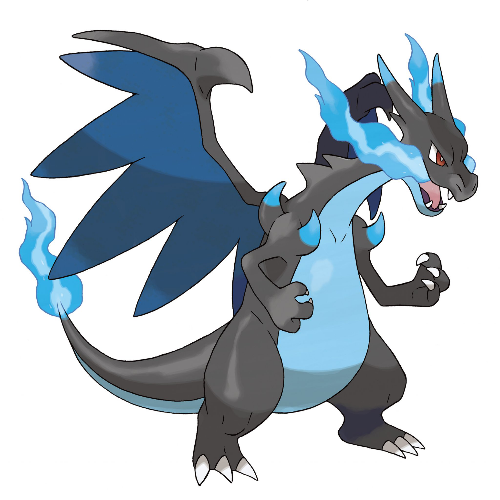

In [11]:
#Importing opencv
import cv2

#Loading the image
image = load_image(filename = "images/mega_charizard.jpg")

#Resizing the image
image = cv2.resize(image, (500,500))

#Plotting the image
plot_image(image)


Recursive level: 0

Image before DeepDream:




Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:




Recursive level: 1

Image before DeepDream:




Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:




Recursive level: 2

Image before DeepDream:




Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:




Recursive level: 3

Image before DeepDream:



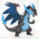


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



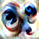


Recursive level: 4

Image before DeepDream:



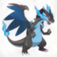


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



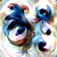


Recursive level: 5

Image before DeepDream:



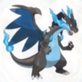


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



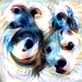


Recursive level: 6

Image before DeepDream:



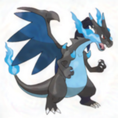


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



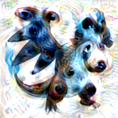


Recursive level: 7

Image before DeepDream:



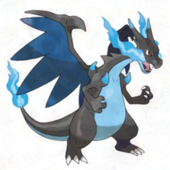


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



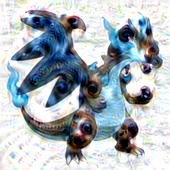


Recursive level: 8

Image before DeepDream:



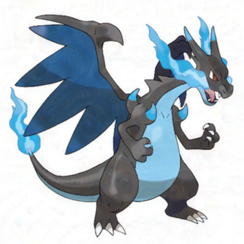


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



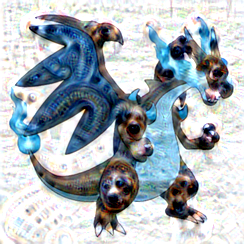


Recursive level: 9

Image before DeepDream:



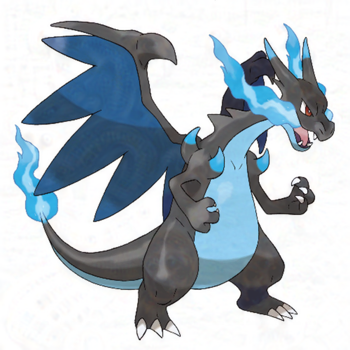


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



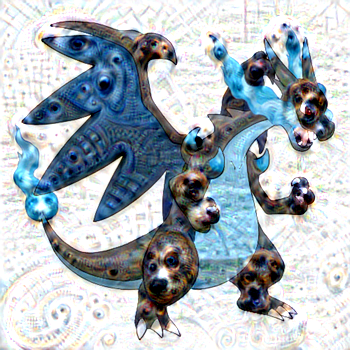


Recursive level: 10

Image before DeepDream:



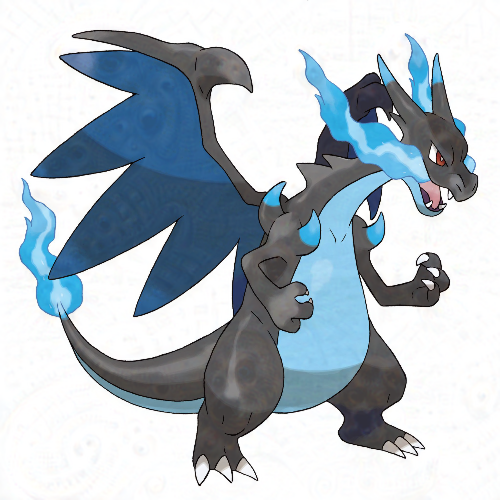


Processing image: 
. . . . . . . . . . . . . . . . . . . . 

Image after DeepDream:



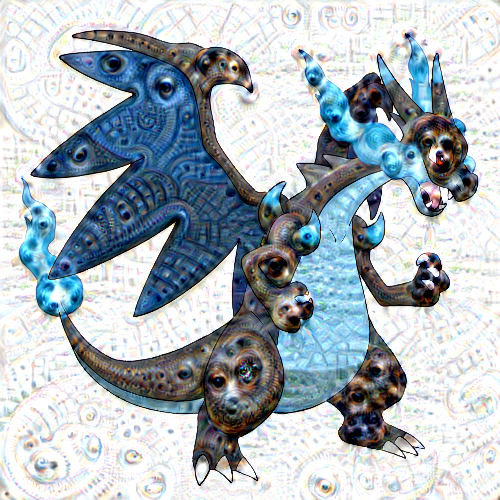

In [12]:
#Specifying the layer from which the gradients are to be extracted to be the sixth layer
layer_tensor = model.layer_tensors[5]

#Retrieving the enhanced image
# enhanced_image = deep_dream(layer_tensor = layer_tensor, image = image, num_iterations = 50, step_size = 6.0)

#Retrieving the enhanced image
enhanced_image = recursive_deep_dream(layer_tensor = layer_tensor, image = image, num_iterations = 20, step_size = 6.0, 
                                      rescale_factor = 0.7, num_repeats = 10, blend = 0.9)

In [13]:
#Saving the enhanced image
save_image(image = enhanced_image, filename = "images/deep_dream_mega_charizard.jpg")

#Closing tensorflow session
session.close()